<div style="border-radius: 15px; border: 3px solid indigo; padding: 15px;">
<b> Комментарий ревьюера</b>
    
    
Привет! Меня зовут Даниил Вяжев, я буду проверять твой проект. Если не против, давай общаться на «ты». Если тебе такой стиль общения не нравится, напиши об этом, будем на «вы».

Сразу хочу обратить внимание на цветовую разметку:

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">

Зеленым с пометкой ✔️ отмечены отличные решения и идеи, которые можно и нужно использовать в будущем.
</div>
    
<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">

Желтым с пометкой ⚠️ отмечено то, что можно или нужно оптимизировать, в зависимости от контекста.</div>    
    
<div class="alert alert-danger" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">

Красным с пометкой ❌ обозначены пропущенные пункты задания и ошибки, которые обязательно надо будет исправить, чтобы результаты были верные.</div> 
    
**Ответы на мои комментарии или доработки по моим рекомендациям попрошу выделить каким-нибудь цветом, кроме перечисленных.**
Также я попрошу тебя **не менять, не передвигать и не удалять мои комментарии**, чтобы при последующей проверке мне было проще ориентироваться.
        
<hr>
    
<font color= 'dodgerblue'>**По проекту:**</font> 
Поздравляю тебя с успешным завершением работы над этим этапом проекта!
    


Отличная работа над проектом! Грамотный подход к решению сложной задачи: от тщательного EDA и качественной предобработки данных с продуманной обработкой специфики твитов, через грамотную реализацию датасетов и работы с последовательностями разной длины, до создания полноценной LSTM-модели с циклом обучения и валидации. Особенно радует твое внимание к деталям - очистке памяти, визуализации, логированию процесса и комплексному сравнению с трансформерной моделью.

Ты успешно справился с ключевыми этапами ML-пайплайна, показал умение работать с разными архитектурами и критически анализировать результаты. Полученные метрики - хороший старт для задачи генерации текста, которая объективно сложна. Продолжай в том же духе!

    
<hr style="border-top: 3px solid purple; "></hr>
Комментарии можешь оставлять с помощью такого кода в Markdown ячейке:
    
    
    <div class="alert alert-info">
    <h2> Комментарий студента</h2>

    Тут текст.
    </div>
    
    
    <font color='red'> Этот код позволяет менять цвет текста. </font>     


  

О том, как **форматировать текст** в Markdown ячейке или как добавлять ссылки, ты можешь узнать [тут](https://sqlbak.com/blog/jupyter-notebook-markdown-cheatsheet) и [вот тут](https://medium.com/analytics-vidhya/the-ultimate-markdown-guide-for-jupyter-notebook-d5e5abf728fd).



Желаю удачи!

<img src="https://user-images.githubusercontent.com/74038190/225813708-98b745f2-7d22-48cf-9150-083f1b00d6c9.gif" width="500">
</div>    



# Нейросеть для автодополнения текстов

Проект направлен на обучение нейронной сети для автодополнения текста

Пропишим необходимые импорты и пути.

In [80]:
from collections import Counter
import gc
import ast

import pandas as pd
import numpy as np

import re

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

from transformers import AutoTokenizer, pipeline

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.model_selection import train_test_split

import evaluate

In [2]:
PATH_ROW_DATA = 'data/raw_dataset.txt'
PATH_PROCESSED_DATA = 'data/processed.csv'
PATH_TRAIN_DATA = 'data/train.csv'
PATH_VALID_DATA = 'data/valid.csv'
PATH_TEST_DATA = 'data/test.csv'

PATH_MODEL = 'models/model.pth'

In [3]:
RANDOM_SEED = 123

In [4]:
tqdm.pandas()

## EDA & Preprocessing

### Предобработка и исследование сырого датасета

Прочитаем данные и посмотрим, что они из себя представляют (выведем первые 10 строк)

In [5]:
with open(PATH_ROW_DATA, 'r', encoding='utf-8') as file:
    texts = file.readlines()

In [6]:
texts[:10]

["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D\n",
 "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!\n",
 '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds\n',
 'my whole body feels itchy and like its on fire \n',
 "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. \n",
 '@Kwesidei not the whole crew \n',
 'Need a hug \n',
 "@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?\n",
 "@Tatiana_K nope they didn't have it \n",
 '@twittera que me muera ? \n']

В данных видны следующие проблемы:
1. Некоторые данные начинаютс с указания аккаунта который писал данный твит, а некоторые нет, поэтому эту часть необходимо удалить.
2. Есть ссылки, поэтому их тоже необходимо зачистить.
3. Все твиты из выведенных заканчиваются симоволом переноса строки, это тоже необходимо будет почистить.
4. Есть смайлики. Необходимо посмотреть это только классические смайлики или ещё есть в формате \*смайлик\*.
5. Необходимо всё привести к нижнему регистру.

Напишем функцию, которая решает данные проблемы.

In [7]:
def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'\w*@\w*', ' ', text) # убираем указани аккаунта и почты
    text = re.sub(r'http\S*', ' ', text) # убираем адреса

    text = re.sub(r"[:;=]['\-]?[)d(p]+", ' ', text) # убираем классические смайлики
    text = re.sub(r'\*\w*\*', ' ', text) # убираем смайлики прописанные в формате слов
    # убираем самйлики в формате кодов
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "]+", flags = re.UNICODE)
    text = regrex_pattern.sub(r'',text)

    text = re.sub(r'\s+([.,!?;:])', r'\1', text) # убираем висячие знаки припинания
    re.sub(r'([.,!?;:])([^\s])', r'\1 \2', text) # добавляем пробелы после знаков припинания, если их нет

    # заменяем все возможные пробелы, переносы и т.д. на стандартный символ пробела и затем заменяем 2 и более пробелов на 1
    text = re.sub(r'_x000d_\n', ' ', text)
    text = re.sub(r'^\s+|\n', ' ', text)
    text = re.sub(r'  ', ' ', text)
    text = re.sub(r'^ +| +$', '', text) # убираем пробелы в начале и конце строки
    return text

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ✔️</b>
    
Функция clean_text очень тщательно обрабатывает текст, учитывая множество edge cases. Это хорошо!

<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ⚠️</b>
    
Результат операции не присваивается переменной text, поэтому этот код не работает. Нужно сохранить результат.

Протестируем на первом примере

In [8]:
clean_text(texts[0])

"- awww, that's a bummer. you shoulda got david carr of third day to do it."

Всё отработало корректно. Почистим все данные и выведем первые 10 примеров.

In [9]:
texts = [clean_text(text) for text in tqdm(texts, desc='Очистка тестка')]

Очистка тестка: 100%|██████████| 1600498/1600498 [00:29<00:00, 54879.35it/s]


In [10]:
texts[:10]

["- awww, that's a bummer. you shoulda got david carr of third day to do it.",
 "is upset that he can't update his facebook by texting it... and might cry as a result school today also. blah!",
 'i dived many times for the ball. managed to save 50% the rest go out of bounds',
 'my whole body feels itchy and like its on fire',
 "no, it's not behaving at all. i'm mad. why am i here? because i can't see you all over there.",
 'not the whole crew',
 'need a hug',
 "hey long time no see! yes.. rains a bit,only a bit lol, i'm fine thanks, how's you?",
 "nope they didn't have it",
 'que me muera?']

Посчитаем количество слов в предложениях.

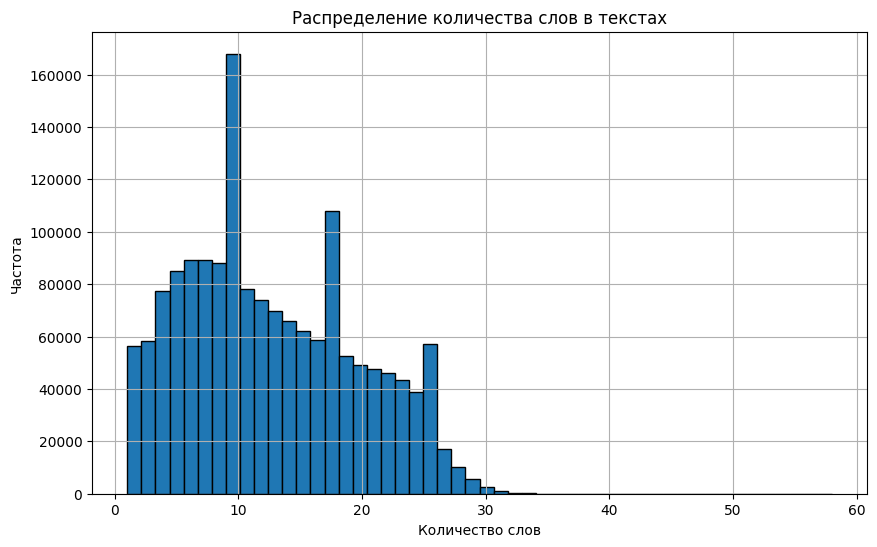

In [11]:
word_counts = [len(text.split(' ')) for text in texts]

plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=50, edgecolor='black')
plt.title("Распределение количества слов в текстах")
plt.xlabel("Количество слов")
plt.ylabel("Частота")
plt.grid(True)
plt.show() 

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ✔️</b>
    
Хорошие визуализации для анализа распределения данных.

Большинство твитов укладывается в 25 слов, но есть редкие твиты в которых порядка 60 слов. Так же есть много твитов состоящих всего из одного ответа.

Посмотрим на количество предложений в которых количество слов превышает или равно 35.

In [12]:
sum([count >= 35 for count in word_counts])

45

Как видим таких твитов было всего лишь 45, поэтому разумно будет убрать их, что бы не делать слишком большие падинги для всех.

In [13]:
mask = [count < 35 for count in word_counts]
texts = [item for item, mask_value in zip(texts, mask) if mask_value]

Посмотрим насколько часто каждое слово встречается в корпусе.

In [14]:
res = []
[res.extend(text.split(' ')) for text in texts]

count_of_words = Counter(res)

Посмотрим на наиболее частые слова

In [15]:
count_of_words.most_common(10)

[('i', 746460),
 ('to', 559664),
 ('the', 518774),
 ('a', 376417),
 ('my', 312774),
 ('and', 294964),
 ('you', 236360),
 ('is', 230800),
 ('for', 213732),
 ('in', 209798)]

Ожидаемо это местоимения, артикли и предлоги

Теперь на наиболее редкие

In [16]:
count_of_words.most_common()[:-10:-1]

[('#flockofseagullsweregeopoliticallycorrect', 1),
 ('texn3rds', 1),
 ('calcio1', 1),
 ('indesign?:', 1),
 ('typeset', 1),
 ('waster)', 1),
 ('flay...', 1),
 ('(updated:', 1),
 ('$palm', 1)]

Редкими оказались хэштеги, опечатки, в том числе с заменок букв на цифры, просто редкие слова плюс слова со знаками препинания (но в этом виновата наша разбивка).

### Токенизация и создание датасетов

Теперь проведём токенизацию нашего датасета.

In [17]:
model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [18]:
token_texts = [tokenizer(text, truncation=True)['input_ids'] for text in tqdm(texts, desc='Очистка тестка')]

Очистка тестка: 100%|██████████| 1600453/1600453 [02:21<00:00, 11285.84it/s]


Посмотрим на результат

In [19]:
token_texts[0]

[12,
 257,
 2503,
 11,
 326,
 338,
 257,
 275,
 31647,
 13,
 345,
 815,
 64,
 1392,
 21970,
 1097,
 81,
 286,
 2368,
 1110,
 284,
 466,
 340,
 13]

Иеперь нам необходимо сформировать три списка: один данные для обучения, второй - цели обучения, третий - оставшаяся часть текста начиная с цели обучения.

In [20]:
def get_data_and_target(token_texts: list[str]) -> tuple[list[str], list[str]]:
    set_tuple = set()
    data_list = []
    target_list = []
    end_list = []
    for text in tqdm(token_texts, desc='Создание списков для обучения'):
        start_point = int(len(text) / 4 * 3) # По заданию для генерации используем 3/4 текста
        for idx_target in range(max(1, start_point), len(text)):
            # Добавляем только уникальные сочетания data/target чтобы избежать дублей
            item = ' '.join([str(i) for i in text[:idx_target + 1]])
            if (item) not in set_tuple:
                set_tuple.add(item)
                data_list.append(text[:idx_target])
                target_list.append(text[idx_target])
                end_list.append(text[idx_target:])
    return data_list, target_list, end_list

<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ⚠️</b>
    
Использование set_tuple для проверки уникальности может привести к избыточному потреблению памяти, так как сохраняются строковые представления последовательностей. Вместо строк лучше использовать кортежи (tuple) для хэширования. Еще можно рассмотреть возможность отказа от проверки уникальности, если данные и так достаточно разнообразны, чтобы избежать затрат памяти.

In [21]:
data_list, target_list, end_list = get_data_and_target(token_texts)

Создание списков для обучения: 100%|██████████| 1600453/1600453 [00:34<00:00, 46823.81it/s]


Посмотрим корректно ли всё отработало

In [22]:
data_list[:5]

[[12,
  257,
  2503,
  11,
  326,
  338,
  257,
  275,
  31647,
  13,
  345,
  815,
  64,
  1392,
  21970,
  1097,
  81,
  286],
 [12,
  257,
  2503,
  11,
  326,
  338,
  257,
  275,
  31647,
  13,
  345,
  815,
  64,
  1392,
  21970,
  1097,
  81,
  286,
  2368],
 [12,
  257,
  2503,
  11,
  326,
  338,
  257,
  275,
  31647,
  13,
  345,
  815,
  64,
  1392,
  21970,
  1097,
  81,
  286,
  2368,
  1110],
 [12,
  257,
  2503,
  11,
  326,
  338,
  257,
  275,
  31647,
  13,
  345,
  815,
  64,
  1392,
  21970,
  1097,
  81,
  286,
  2368,
  1110,
  284],
 [12,
  257,
  2503,
  11,
  326,
  338,
  257,
  275,
  31647,
  13,
  345,
  815,
  64,
  1392,
  21970,
  1097,
  81,
  286,
  2368,
  1110,
  284,
  466]]

In [23]:
target_list[:5]

[2368, 1110, 284, 466, 340]

In [24]:
end_list[:5]

[[2368, 1110, 284, 466, 340, 13],
 [1110, 284, 466, 340, 13],
 [284, 466, 340, 13],
 [466, 340, 13],
 [340, 13]]

Всё отработало корректно. Теперь создадим датафрейм и сохраним его

In [25]:
df = pd.DataFrame({
    'data': data_list,
    'target': target_list,
    'end_text': end_list
})
df.head()

,data,target,end_text
0,"[12, 257, 2503, 11, 326, 338, 257, 275, 31647,...",2368,"[2368, 1110, 284, 466, 340, 13]"
1,"[12, 257, 2503, 11, 326, 338, 257, 275, 31647,...",1110,"[1110, 284, 466, 340, 13]"
2,"[12, 257, 2503, 11, 326, 338, 257, 275, 31647,...",284,"[284, 466, 340, 13]"
3,"[12, 257, 2503, 11, 326, 338, 257, 275, 31647,...",466,"[466, 340, 13]"
4,"[12, 257, 2503, 11, 326, 338, 257, 275, 31647,...",340,"[340, 13]"


In [26]:
df.shape

(7337114, 3)

Сохраним полученный датафрейм

In [27]:
df.to_csv(PATH_PROCESSED_DATA, index=False)

Разделим датасет на тренировочный, валидационный и тестовый

In [28]:
df_train, df_test= train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_valid, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

Выведем размеры получившихся датасетов

In [29]:
df_train.shape, df_valid.shape, df_test.shape

((5869691, 3), (733711, 3), (733712, 3))

In [30]:
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

Сохраним их.

In [31]:
df_train.to_csv(PATH_TRAIN_DATA, index=False)
df_valid.to_csv(PATH_VALID_DATA, index=False)
df_test.to_csv(PATH_TEST_DATA, index=False)

Удалим ненужные перемнные, чтобы не засорять память.

In [32]:
del texts, token_texts, df
gc.collect()

0

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ✔️</b>
    
Отличное использование gc.collect() и удаление ненужных переменных для оптимизации использования памяти!

## Modeling

Поскольку в качестве метрики будем использовать rouge, то сразу загрузим ей

In [33]:
rouge = evaluate.load("rouge")

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ✔️</b>
    
Отличное использование метрик и сравнение с baseline-моделью!

Также проверим доступна ли нам cuda и присвоим соответствующее значение переменной device

In [34]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device='cpu'

print(device)

cuda


### Создание Даталоадеров

Зададим максимальную длину последовательности (как мы знаем она у нас не превышает 35), а также получен токен для паддинга.

In [35]:
MAX_LEN = 35
PAD_TOKEN = tokenizer.pad_token_type_id

<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ⚠️</b>
    
Переменная PAD_TOKEN определена как tokenizer.pad_token_type_id, но для паддинга обычно используется tokenizer.pad_token_id. Это может привести к некорректному паддингу.

Напишем класс датасета

In [36]:
class Custom_Dataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.data = df['data']
        self.target = df['target']
        self.end_text = df['end_text']

    def __len__(self) -> int:
        return len(self.target)
    
    def __getitem__(self, index):
        return {
            'data': torch.tensor(self.data[index], dtype=torch.long),
            'target': torch.tensor(self.target[index], dtype=torch.long),
            'end_text': torch.tensor(self.end_text[index], dtype=torch.long),
        }

Создадим функцию collate_fn для более эффективного создания паддингов

In [37]:
def collate_fn(batch):
    data = [i['data'] for i in batch]
    target = torch.stack([i['target'] for i in batch])
    end_text = [i['end_text'] for i in batch]
    max_len = max([len(i) for i in data])
    max_len = min([MAX_LEN, max_len])

    pad_text = pad_sequence(data, batch_first=True, padding_value=PAD_TOKEN)

    masks = (pad_text != 0).long()

    return {
        'data': pad_text,
        'target': target,
        'end_text': end_text,
        'masks': masks
    }   

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ✔️</b>
    
Отличная реализация collate_fn с паддингом и созданием масок внимания. Молодец!

Создадим датасеты и даталоадеры и протестируем корректность работы кода.

In [38]:
train_dataset = Custom_Dataset(df_train)
valid_dataset = Custom_Dataset(df_valid)
test_dataset = Custom_Dataset(df_test)

In [39]:
train_dataloader = DataLoader(train_dataset, batch_size=128, collate_fn=collate_fn, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=128, collate_fn=collate_fn, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn, shuffle=False)

Создадим отдельный даталоадер для эксперимента с меньшим размером батча

In [40]:
exp_dataloader = DataLoader(train_dataset, batch_size=3, collate_fn=collate_fn, shuffle=False)

In [41]:
for batch in exp_dataloader:
    print('data:\n', batch['data'])
    print('target:\n', batch['target'])
    print('end_text:', batch['end_text'])
    print('masks:', batch['masks'])
    break

data:
 tensor([[20342,   492,   703,   373,   262,  3491, 30784,  3807,   492,  1312,
           691,   760,   530,  1048,   508,  2497,   340,  4145,     0,     0,
             0,     0],
        [ 8807,  1760,   604,  2250,   290,  2319, 23550,   286, 18440,   523,
          1290,  1909,   986,  1521,   423,  1312,  1716,   523, 16931,  3548,
         14643,   783],
        [ 5832,   821,   884,   257,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])
target:
 tensor([ 1290,    11, 16443])
end_text: [tensor([ 1290,    11,   523,  1312,   373, 11040]), tensor([ 11, 788, 275,  65,  13]), tensor([16443,  3956])]
masks: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


Всё работает корректно, удалим экспериментальный даталоадер

In [42]:
del exp_dataloader
gc.collect()

423

### Создание LSTM модели.

Создадим класс модели.

In [43]:
class LSTMGenerator(nn.Module):
    def __init__(self, tokenizer, embedding_dim=128, hidden_dim=128):
        super().__init__()
        self.tokenizer = tokenizer

        self.embeding = nn.Embedding(tokenizer.vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, embedding_dim, batch_first=True)
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, tokenizer.vocab_size)

    def forward(self, input_ids, attention_mask):
        x = self.embeding(input_ids)
        rnn_out, _ = self.lstm(x)

        rnn_out_normed = self.norm(rnn_out)

        mask = attention_mask.unsqueeze(2).expand_as(rnn_out_normed)
        masked_out = rnn_out_normed * mask
        summed = masked_out.sum(dim=1)
        lengths = attention_mask.sum(dim=1).unsqueeze(1)
        mean_pooled = summed / lengths

        out = self.dropout(mean_pooled)
        logits = self.fc(out)

        return logits
    
    def generate(self, input_ids, attention_mask, max_len=20):
        num_words = 0
        while num_words < max_len:
            logits = self.forward(input_ids, attention_mask)
            token = logits.argmax(dim=1)

            # input_ids = torch.cat((input_ids[0], torch.tensor([token]).to(device))).unsqueeze(dim=0)
            # attention_mask = torch.cat((attention_mask[0], torch.tensor([1]).to(device))).unsqueeze(dim=0)

            input_ids = torch.cat([input_ids, token.unsqueeze(dim=1)], dim=1)
            new_token_mask = (token != tokenizer.eos_token_id).long()
            attention_mask = torch.cat([attention_mask, new_token_mask.unsqueeze(dim=1)], dim=1)
            
            num_words += 1

            # раняя остановка, если все новые токены стали eos
            if new_token_mask.sum() == 0:
                return input_ids.to('cpu')   
                               
        return input_ids.to('cpu')

<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ⚠️</b>
    
В методе generate используется конкатенация токенов без ограничения длины, что может привести к превышению MAX_LEN. Рекомендую использовать masked pooling или берите последний hidden state вместо усреднения по всем временным шагам, так как для генерации важен контекст конца последовательности.

In [44]:
model = LSTMGenerator(tokenizer).to(device)

Создадим оптимайзер и критерий оцнивания

In [45]:
optimizer = torch.optim.Adam(params=model.parameters(),  lr=2e-3)
criterion = nn.CrossEntropyLoss()

Напишем функцию для тренировки 1 эпохи

In [46]:
def train_epoch(model: LSTMGenerator, loader: DataLoader) -> float:
    train_loss = 0
    model.train()
    for batch in loader:
        data = batch['data'].to(device)
        masks = batch['masks'].to(device)
        target = batch['target'].to(device)

        optimizer.zero_grad()
        output = model(data, masks)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()

        train_loss += loss
    
    return train_loss / len(loader)

Напишем функцию для валидации

In [47]:
def eval(model: LSTMGenerator, loader: DataLoader) -> float:
    valid_loss = 0
    preds, trues = [], []
    model.eval()

    for batch in loader:
        data = batch['data'].to(device)
        masks = batch['masks'].to(device)
        target = batch['target'].to(device)

        with torch.no_grad():
            output = model(data, masks)
            loss = criterion(output, target)
            valid_loss += loss

            preds += torch.argmax(output.squeeze(1), dim=1).cpu().tolist()
            trues += target.tolist()

    preds = [tokenizer.decode(pred) for pred in preds]
    trues = [tokenizer.decode(true) for true in trues]

    return valid_loss / len(loader), rouge.compute(predictions = preds, references = trues)['rouge1']

Напишем основной цикл обучения

In [48]:
PATION = 10
best_val = np.inf
train_losses = []
valid_losses = []
metrics = []

best_epoch = 0
no_improve_epochs = 0

for epoch in range(200):
    train_loss = train_epoch(model, train_dataloader)
    valid_loss, rouge1 = eval(model, valid_dataloader)

    train_losses.append(train_loss.item())
    valid_losses.append(valid_loss.item())
    metrics.append(rouge1)

    if valid_loss < best_val:
        best_val = valid_loss
        best_epoch = epoch
        no_improve_epochs = 0
        torch.save(model.state_dict(), PATH_MODEL)

    else:
        no_improve_epochs += 1
        if no_improve_epochs > PATION:
            break

    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}: Train loss = {train_loss:.4f}")
        print(f"Epoch {epoch+1}: Valid loss = {valid_loss:.4f}, Rouge1 = {rouge1:.4f}") 

print('-' * 20)
print(f'Best epoch: {best_epoch + 1}')
print(f'Best validation loss: {best_val:.4f}')
print(f'Best metric rouge1: {metrics[best_epoch]:.4f}')

Epoch 1: Train loss = 6.1437
Epoch 1: Valid loss = 5.6641, Rouge1 = 0.0837
Epoch 11: Train loss = 5.5574
Epoch 11: Valid loss = 5.4631, Rouge1 = 0.1011
Epoch 21: Train loss = 5.5816
Epoch 21: Valid loss = 5.5163, Rouge1 = 0.0976
--------------------
Best epoch: 16
Best validation loss: 5.4502
Best metric rouge1: 0.1024


<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ✔️</b>
    
Хорошо реализованный тренировочный цикл с early stopping и сохранением лучшей модели.

<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ⚠️</b>
    
Советую использовать Learning Rate Scheduler (например, ReduceLROnPlateau) для улучшения сходимости.

Построим графики лоссов и метрики

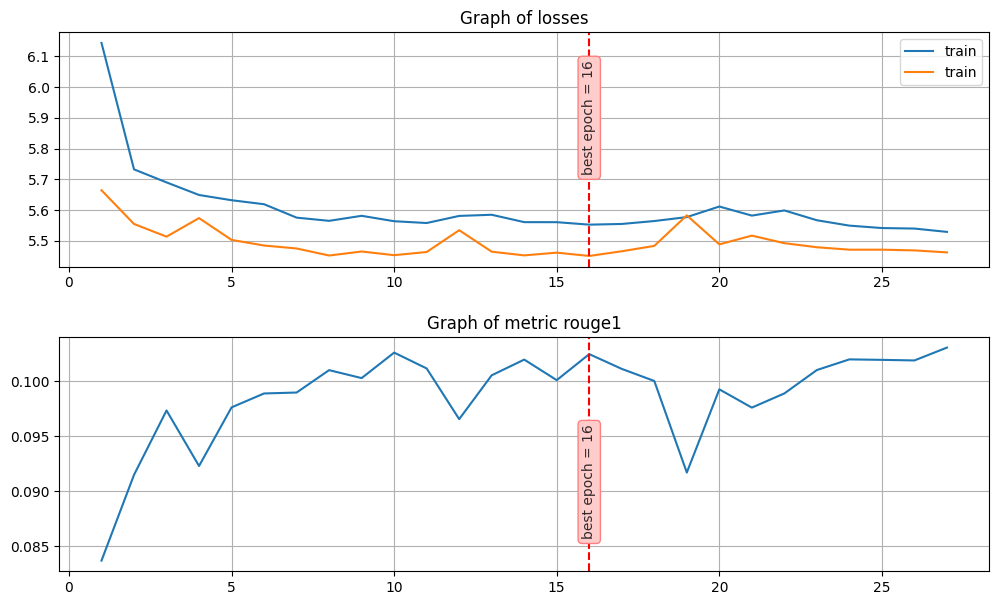

In [49]:
fig, axes = plt.subplots(2, 1, figsize=(12, 7))
plt.subplots_adjust(hspace=0.3)

axes[0].set_title(f"Graph of losses")
axes[0].plot(list(range(1, len(train_losses) + 1)), train_losses, label='train')
axes[0].plot(list(range(1, len(valid_losses) + 1)), valid_losses, label='train')
axes[0].axvline(best_epoch + 1, linestyle='--', color='r')
axes[0].legend()
axes[0].grid()
axes[0].text(best_epoch + 1,
            max([min(train_losses), min(valid_losses)]) + 0.3 * (max(train_losses) - min(train_losses)),
            f'best epoch = {best_epoch + 1}',
            size=10,
            alpha=0.8,
            rotation='vertical',
            ha="center",
            va="bottom",
            bbox=dict(boxstyle="round",
                    ec=(1., 0.5, 0.5),
                    fc=(1., 0.8, 0.8),
                    )
            )


axes[1].set_title(f"Graph of metric rouge1")
axes[1].plot(list(range(1, len(metrics) + 1)), metrics)
axes[1].axvline(best_epoch + 1, linestyle='--', color='r')
axes[1].grid()
axes[1].text(best_epoch + 1,
            min(metrics) + 0.1 * (max(metrics) - min(metrics)),
            f'best epoch = {best_epoch + 1}',
            size=10,
            alpha=0.8,
            rotation='vertical',
            ha="center",
            va="bottom",
            bbox=dict(boxstyle="round",
                    ec=(1., 0.5, 0.5),
                    fc=(1., 0.8, 0.8),
                    )
            )

plt.show()

Загрузим лучшую обученную модель

In [50]:
model.load_state_dict(torch.load(PATH_MODEL, weights_only=True))

<All keys matched successfully>

Напишем функцию для генерации текста, которая будет сразу проводить ткоенезацию в прямом и обратном направлении.

In [51]:
def generate(model: LSTMGenerator, text: str, max_token:int = 20) -> str:
    token = tokenizer(text.lower())
    text = token['input_ids']
    masks = token['attention_mask']
    answ = model.generate(torch.tensor(text, dtype=torch.long).unsqueeze(dim=1).to(device), torch.tensor(masks, dtype=torch.long).unsqueeze(dim=1).to(device), max_token)
    answ = tokenizer.decode(answ[0][len(text):])
    return answ

In [52]:
generate(model, 'I want to')


". sorry. i'm feeling sick. i'm sick. i'm sick. i'm"

In [78]:
generate(model, 'This comment is')

" sad. i'm so tired. i'm so tired. i'm tired. i'm"

Моделька иногда галюцианирует и зацикливается, но местами смысл и правильный порядок слов наблюдается.

Пройдёмся по тестовому датасету и посмотрим на качество модели.

In [54]:
model.eval()
preds, trues = [], []

for batch in test_dataloader:
    data = batch['data'].to(device)
    masks = batch['masks'].to(device)
    end_text = batch['end_text']

    with torch.no_grad():
        output = model.generate(data, masks)
        preds += output
        trues += end_text

preds = [tokenizer.decode(pred) for pred in preds]
trues = [tokenizer.decode(true) for true in trues]

results = rouge.compute(predictions = preds, references = trues)

for key, value in results.items():
    print(f"{key}: {value:.4f}") 

rouge1: 0.0275
rouge2: 0.0021
rougeL: 0.0258
rougeLsum: 0.0258


In [79]:
del model
gc.collect()
torch.cuda.empty_cache()
gc.collect()

0

### Использование предобученной модели трансформера

В качестве предобученной модели будем использовать distilgpt2

In [135]:
generator = pipeline("text-generation", model="distilgpt2", device=device, pad_token_id=tokenizer.eos_token_id)

Device set to use cuda


Проверим как генерируется текст в тех же примерах, что и ЛСТМ.

In [87]:
result = generator("I want to", max_length=20, do_sample=True)
print(result[0]["generated_text"]) 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


I want to know what happens when we're not playing with the other team.”


In [119]:
result = generator("This comment is", max_length=20, do_sample=True)
print(result[0]["generated_text"]) 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


This comment is not for sale.







To make this a reality, let me tell you that I am a gamer about the importance of a high-level game which is about to change.
And if so, then I would like to share your thoughts on the current game and its development.
There are many reasons why I hope that this article will help you to make more informed comments and help you to make a better game. I hope that you will be able to learn more about this game and its development on the future.
Here is a few more thoughts that I wish you all the best in your life.


Текст получается более связанным, хотя модель тоже галлюцианирует.

Посмотрим наметрики трансформера на тестовом датасете (Поскольку генерацию запимает примерно 11 секунд на 100 строк, то для анализа будем рассматривать 3000 строк).

In [139]:
test_data = [tokenizer.decode(data) for data in df_test.loc[:3000, 'data']]
trues = [tokenizer.decode(end) for end in df_test.loc[:3000, 'end_text']]

In [140]:
result = generator(test_data, max_new_tokens=20, do_sample=True)

In [141]:
preds = [res[0]["generated_text"] for res in result]

Удалим в предиктах, ту часть которая подавалась на вход.

In [152]:
for i, (pred, data) in enumerate(zip(preds, test_data)):
    preds[i] = pred[len(data):]

In [154]:
results = rouge.compute(predictions = preds, references = trues)
for key, value in results.items():
    print(f"{key}: {value:.4f}") 

rouge1: 0.0384
rouge2: 0.0036
rougeL: 0.0378
rougeLsum: 0.0378


Как видим качество не много лучше чем у нашей модели, но тоже не очень высокое, вероятнее всего это связано с тем, что твити, сами по себе весьма специфичный домен. Помотрим на первые 10 генераций

In [155]:
preds[:10]

['!!\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n',
 ' up their work.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n',
 'up&quot;up&quot;up&quot;up&quot;',
 'oompp.\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n',
 '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n',
 ' take advantage of...\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n',
 " the entrance. I'll be back in no time to answer this question again. The main thing here",
 "'s really been a long day, though i'm not really sure why. i guess because i've",
 " time for them to break the news.\n\n\n\nIt's still not clear if the publisher",
 "iting. I'm not going to lie if I told them to. That's a lie, man"]

Видно, что иногда модель зацикливается и она тоже галюционирует.

## Выводы

В данном проекте была рассмотрена задача генерации текста при помощи нейросетей. Проект условно можно разделить на 3 части:
1. В первой части нами был проанализирован и почищен датасет товитов было установленно, что как правило твиты не превышают 35 слов. так же нами была проведена токенизация текста и выделены тренировочные, валидационные и тестовые данные.
2. Во второй части были созданны кастомные классы датасетов и функция collate_fn, такж был создан класс модели на базе архитектуры LSTM. Модель была обучена и проверено качество генерации текста. Модель можно попробовать доработать (возможно, уменьшение lr позволит сойтись до более низкого значения лосса, хотя и увеличит время обучения; так же стоит попробовать боле жёстко почистить исходные данные и убрать повторяющиеся знаки препинания, что позволит модели реже зацикливаться).
3. В третьей части была рассмотрена предобученная модель архитектуры трансформера, она генерирует более связный текст и на тестовых данных показала себя немного лучше чем LSTM, хотя она тоже иногда галлюционировала.

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ✔️</b>
    
Хорошо структурированные выводы по итогам работы. Отлично!

<div class="alert alert-success" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Комментарий ревьюера  ✔️</b>
    
Отличная работа над проектом! Грамотный подход к решению сложной задачи: от тщательного EDA и качественной предобработки данных с продуманной обработкой специфики твитов, через грамотную реализацию датасетов и работы с последовательностями разной длины, до создания полноценной LSTM-модели с циклом обучения и валидации. Особенно радует твое внимание к деталям - очистке памяти, визуализации, логированию процесса и комплексному сравнению с трансформерной моделью.

Ты успешно справился с ключевыми этапами ML-пайплайна, показал умение работать с разными архитектурами и критически анализировать результаты. Полученные метрики - хороший старт для задачи генерации текста, которая объективно сложна. Продолжай в том же духе!